In [284]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc, plot_confusion_matrix

from catboost import CatBoostClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [241]:
df = pd.read_csv('C:\\Users\\Muhammad Hazim\\Desktop\\bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [242]:
df.isnull().any().any()

False

In [243]:
cat_feat = []
num_feat = []

for column in df.drop('deposit', axis = 1).columns.values:
    if df[column].nunique() < 20:
        cat_feat.append(column)   
    else: 
        num_feat.append(column)

<AxesSubplot:xlabel='deposit', ylabel='count'>

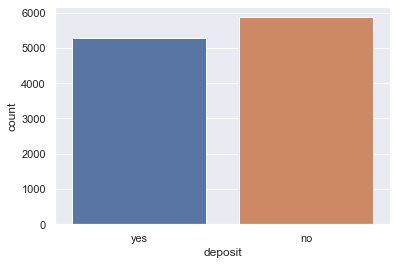

In [244]:
sns.countplot(df['deposit'])

In [245]:
def distribution_num_feat(column):
    fix, ax = plt.subplots(1, 3, figsize = (20,5))

    sns.distplot(df[column], ax = ax[0])
    sns.boxplot(df[column], ax = ax[1])
    sns.boxplot(df['deposit'], df[column], ax = ax[2])

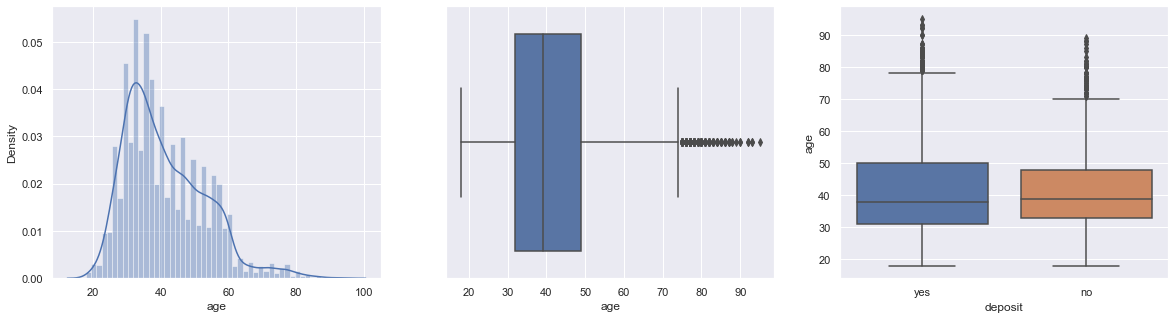

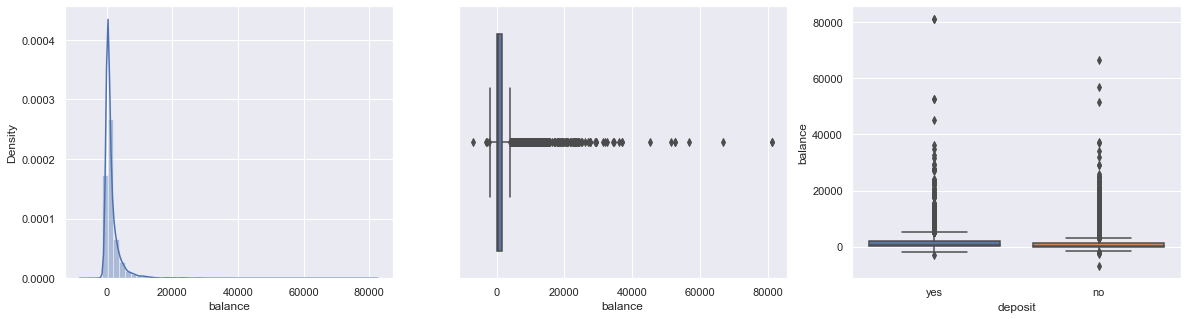

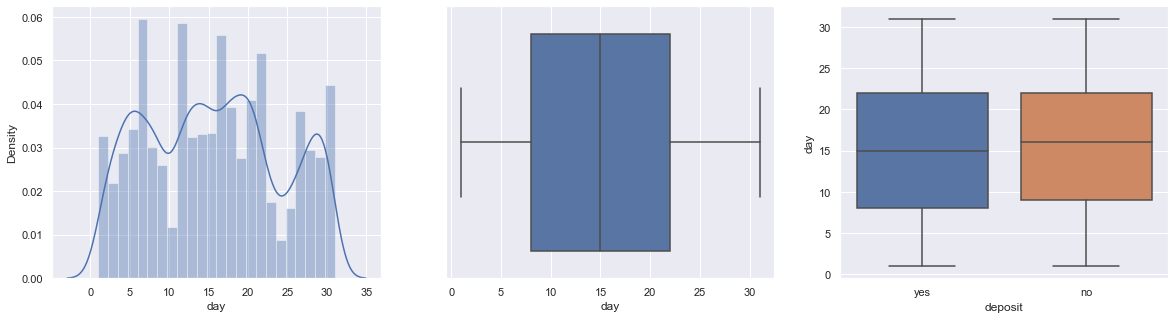

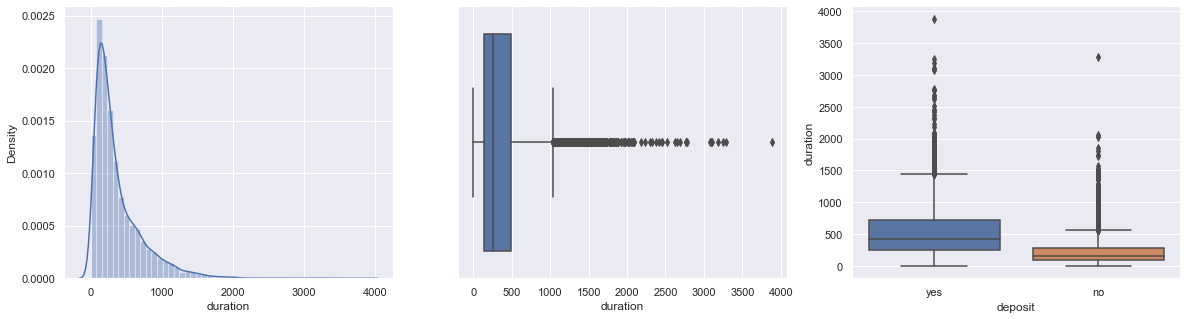

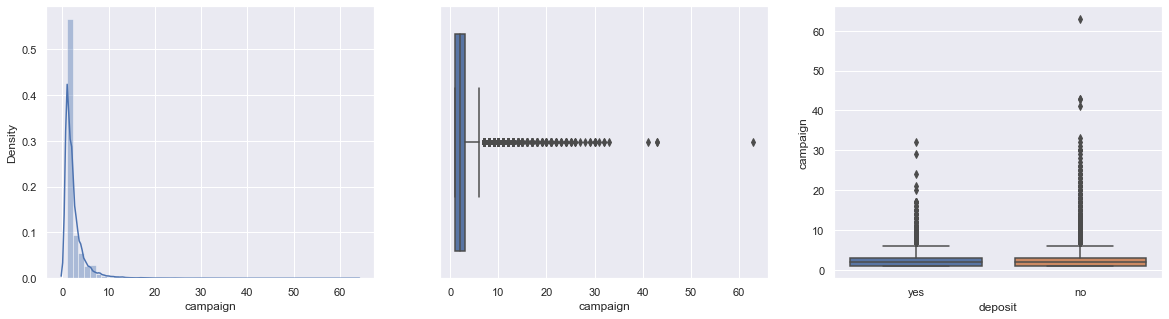

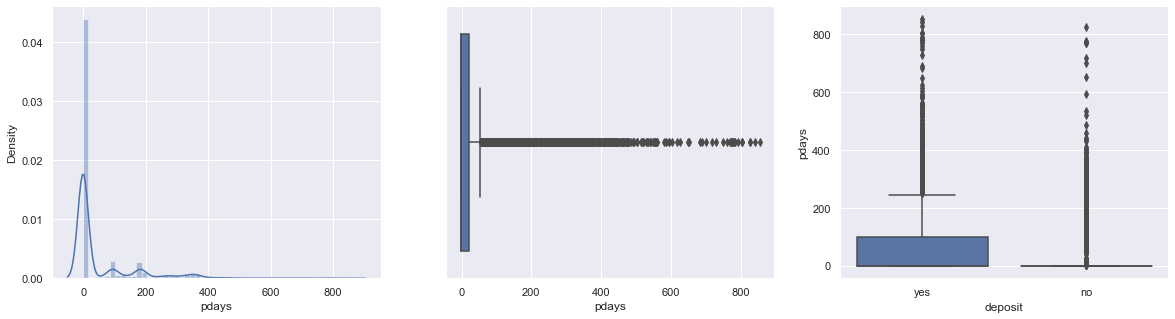

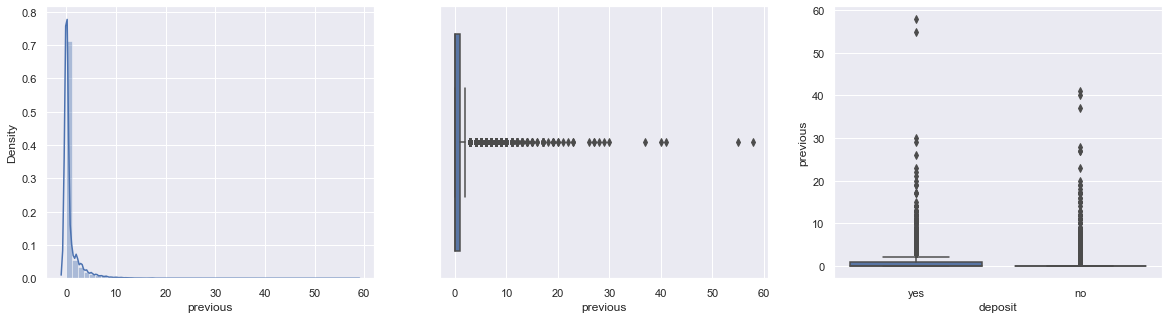

In [246]:
for column in num_feat:
    distribution_num_feat(column)

In [247]:
df.deposit = df.deposit.map({'yes':1, 'no':0})

In [248]:
def distribution_cat_feat(column):
    fix, ax = plt.subplots(1, 2, figsize = (15,5))

    sns.countplot(df[column], ax = ax[0])
    df[[column, 'deposit']].groupby(column).mean().sort_values(by = 'deposit', ascending = False).plot(kind = 'bar', ax = ax[1])

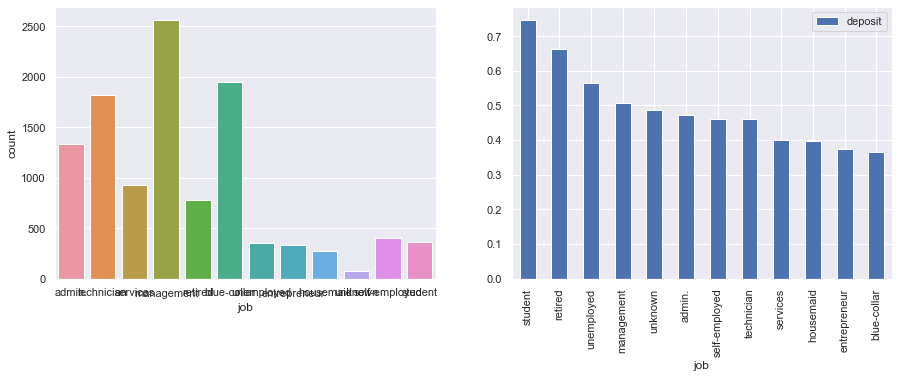

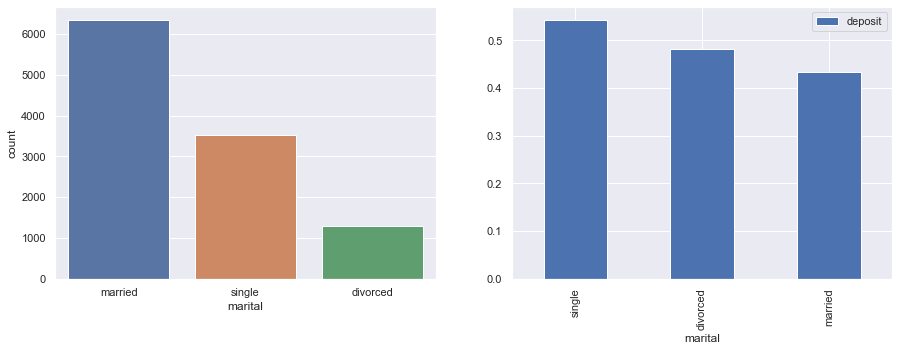

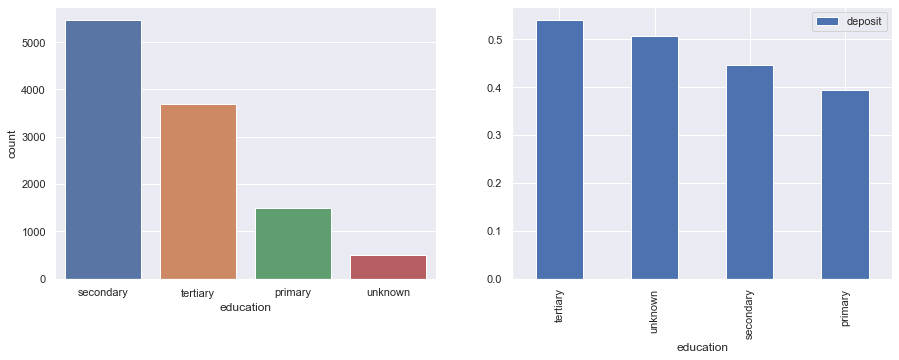

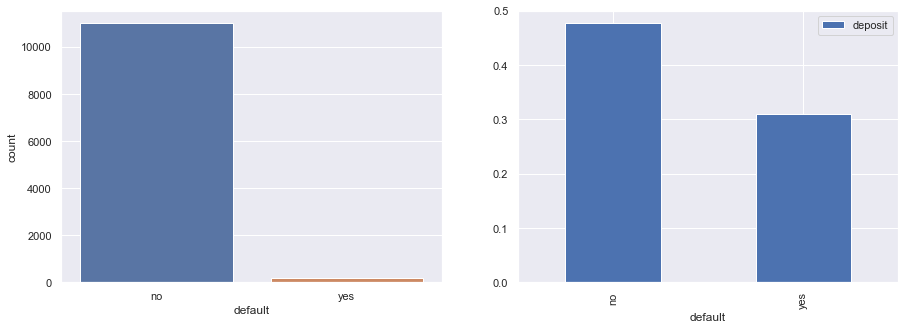

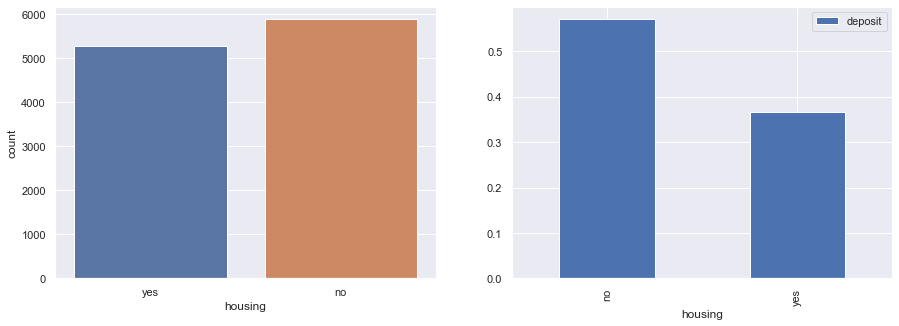

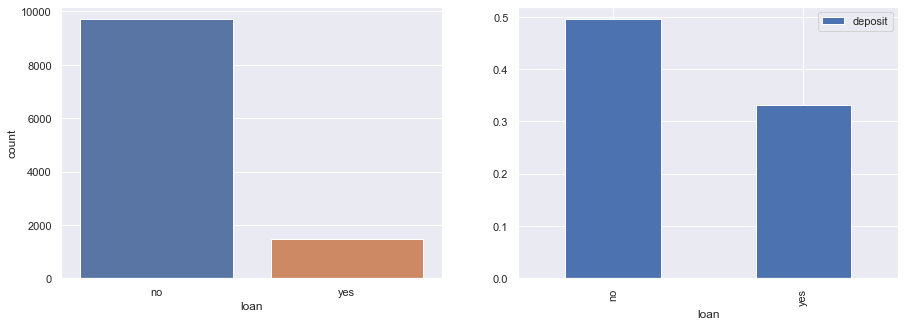

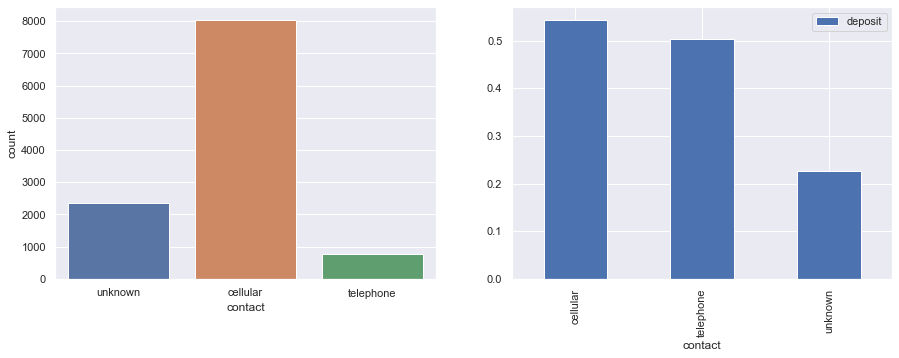

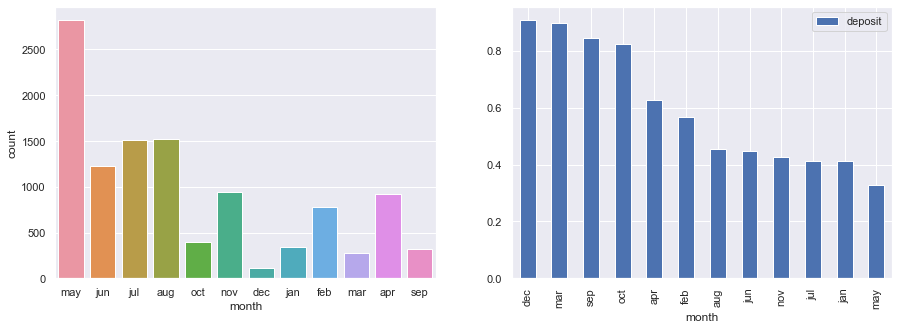

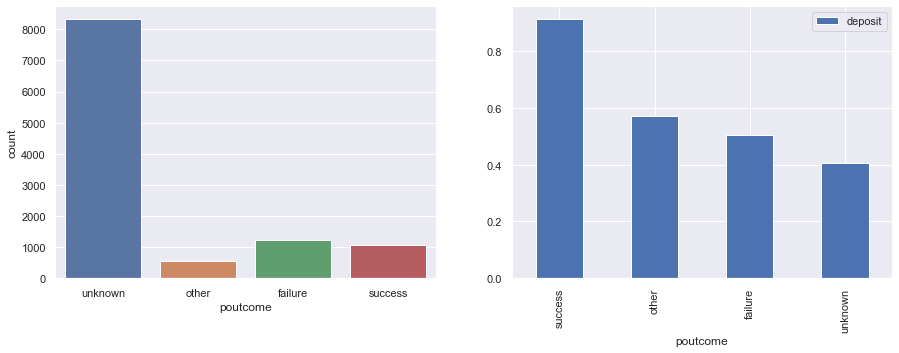

In [249]:
for column in cat_feat:
    distribution_cat_feat(column)

<AxesSubplot:>

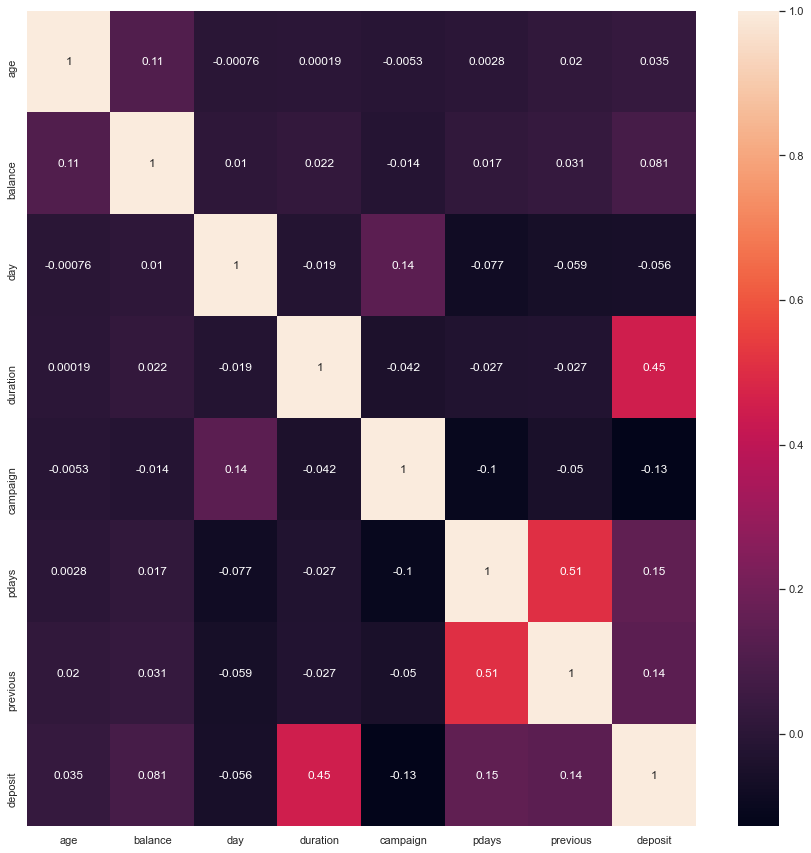

In [250]:
plt.figure(figsize = (15, 15))
sns.heatmap(df.corr(), annot = True)

In [251]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,deposit
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557,0.473840
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007,0.499338
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000,1.000000


In [252]:
df.loc[ df['age'] <= 25, 'age'] = 1
df.loc[(df['age'] > 25) & (df['age'] <= 35), 'age'] = 2
df.loc[(df['age'] > 35) & (df['age'] <= 45), 'age'] = 3
df.loc[(df['age'] > 45) & (df['age'] <= 60), 'age'] = 4
df.loc[ df['age'] > 60, 'age'] = 5

<AxesSubplot:xlabel='age'>

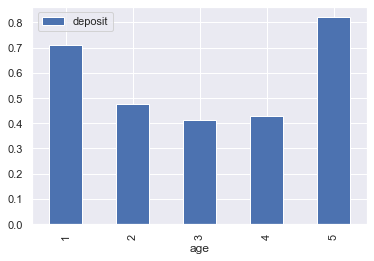

In [253]:
df[['age', 'deposit']].groupby('age').mean().sort_values(by = 'age').plot(kind = 'bar')

In [254]:
df.duration = df.duration/60

In [256]:
df.pdays = df.pdays.replace(-1,0)

In [257]:
df.default = df.default.map({'no':0, 'yes':1})

In [258]:
df.housing = df.housing.map({'no':0, 'yes':1})

In [259]:
df.loan = df.loan.map({'no':0, 'yes':1})

In [260]:
x = df.drop("deposit", axis=1)
y = df["deposit"]

In [261]:
categorical_features = np.where(x.dtypes != np.float)[0]
categorical_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15],
      dtype=int64)

In [262]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1, stratify = y)

In [263]:
cb=CatBoostClassifier(learning_rate=0.001, eval_metric='AUC')
cb.fit(x_train, y_train, cat_features = categorical_features, eval_set=(x_test, y_test),verbose = False ,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [264]:
def score(model):
    df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'ROC AUC'] )
    df1['Train Score'] = [accuracy_score(y_train, model.predict(x_train)), precision_score(y_train, model.predict(x_train)), recall_score(y_train, model.predict(x_train)), roc_auc_score(y_train, model.predict_proba(x_train)[:,1])]
    df1['Test Score'] = [accuracy_score(y_test, model.predict(x_test)), precision_score(y_test, model.predict(x_test)), recall_score(y_test, model.predict(x_test)), roc_auc_score(y_test, model.predict_proba(x_test)[:,1])]        
    return df1

In [265]:
score(cb)

,Train Score,Test Score
Accuracy,0.860343,0.842365
Precision,0.829651,0.804836
Recall,0.887497,0.880907
ROC AUC,0.931547,0.912017


In [266]:
def build_feature_importance(model, x_train, y_train):
    
    data = pd.DataFrame(model.feature_importances_, x.columns.values, columns=["feature"])
    data = data.sort_values(by='feature', ascending=False).reset_index()
    plt.figure(figsize=[12,8])
    sns.barplot(x ='index', y='feature', data=data[:10], palette="Blues_d")
    plt.title('Feature inportance of {}'.format(model))
    plt.xticks(rotation=45)
    plt.show();

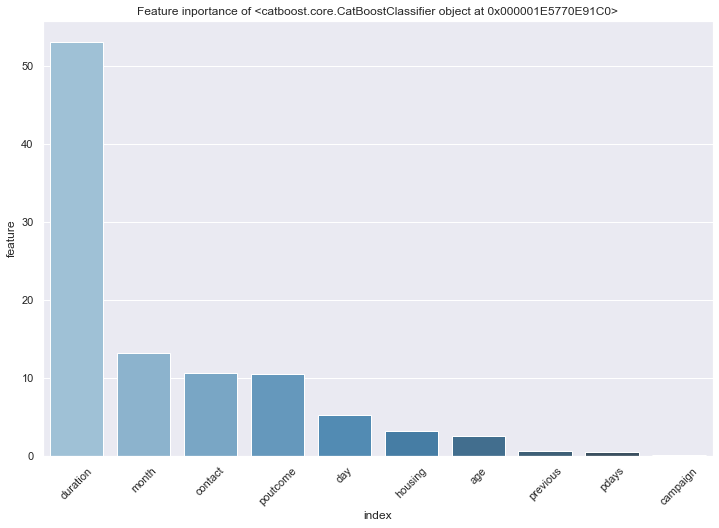

In [267]:
build_feature_importance(cb, x_train, y_train)

In [268]:
import shap  # package used to calculate Shap values
# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

from catboost import CatBoostClassifier, Pool
shap_values = cb.get_feature_importance(Pool(x_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], x_test.iloc[0,:])

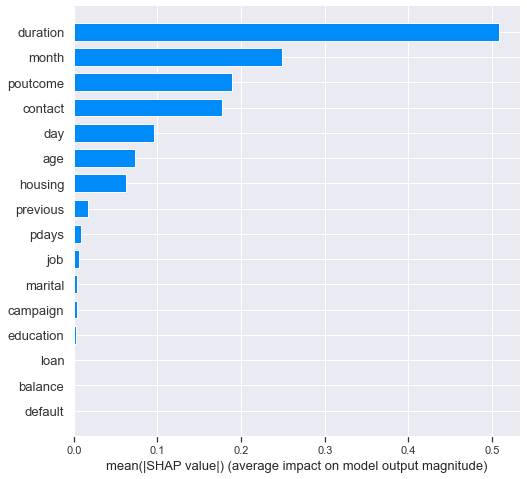

In [269]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

In [271]:
y_prob_train = cb.predict_proba(x_train)[:,1]
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(y_train, y_prob_train)
roc_auc_train = auc(false_positive_rate, true_positive_rate)
roc_auc_train

0.9275803399558613

In [272]:
y_prob_test = cb.predict_proba(x_test)[:,1]
false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(false_positive_rate, true_positive_rate)
roc_auc_test

0.9275803399558613

Text(0.5, 0, 'False Positive Rate')

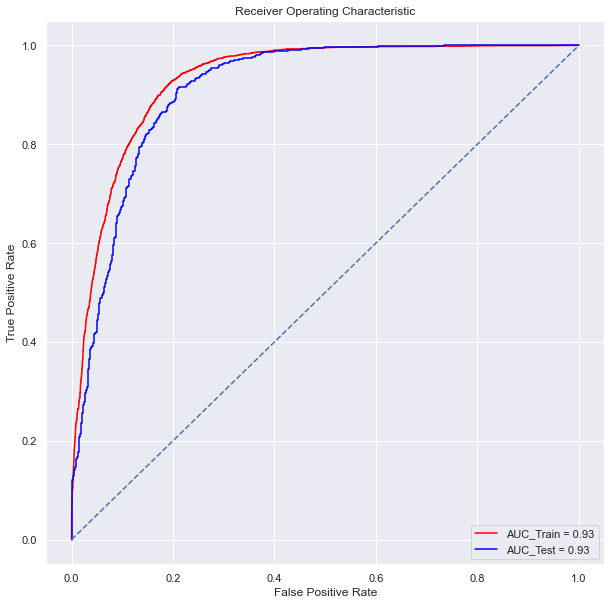

In [273]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_train,true_positive_rate_train, color='red',label = 'AUC_Train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot(false_positive_rate_test,true_positive_rate_test, color='blue',label = 'AUC_Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

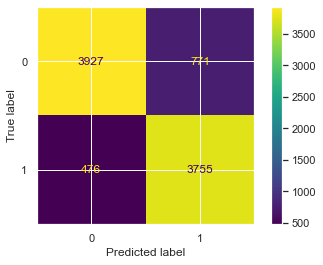

In [281]:
plot_confusion_matrix(cb, x_train, y_train);

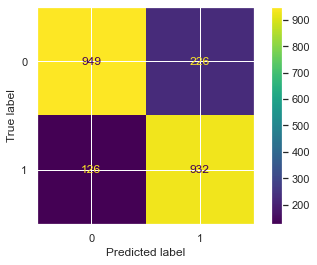

In [282]:
plot_confusion_matrix(cb, x_test, y_test);